# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science 


## Lab 3: Multiple Regression - Polynomial Regression - Subgroup Exploration
**Harvard University**<br>
**Summer 2018**<br>
**Instructors:** Pavlos Protopapas and Kevin Rader  
**Authors:** Will Claybaugh, David Sondak, Pavlos Protopapas

---

## <font color='red'> Run the cell below to properly highlight the exercises</font>

In [1]:
from IPython.display import HTML
style = "<style>div.exercise { background-color: #ffcccc;border-color: #E9967A; border-left: 5px solid #800080; padding: 0.5em;}</style>"

HTML(style)

## Learning Goals
After this lab, you should be able to
 - Implement arbitrary multiple regression models in both SK-learn and Statsmodels
 - Interpret the coefficent estimates produced by each model, including transformed and dummy variables
 - Explore and visualize relationships among variables using tools such as `groupby`, `agg`, and `violinplot`
 - Work more fluently within Pandas to build dataframes and select items of interest

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Motivation: Why we need multiple predictors
If you have to guess someone's height, would you rather be told
<ol type="a">
<li>Their weight, only</li>
<li>Their weight and gender</li>
<li>Their weight, gender, and income</li>
<li>Their weight, gender, income, and favorite number</li>
</ol>

Of course, you'd always want as much data about a person as possible. Even though height and favorite number may not be strongly related, at worst you could just ignore the information on favorite number. We want our models to be able to take in lots of data as they make their predictions.

Here is a small example to illustrate this point:

In [5]:
# visualize the relationships in the data
from pandas.plotting import scatter_matrix

df = pd.read_csv("data/example1_train.csv", index_col=0)

scatter_matrix(df);
plt.show()

for var_to_keep in ['var1','var2']:
    fitted_ols = OLS(df['target'], sm.add_constant(df[var_to_keep])).fit()    
    print("R^2 for model with only {}: {}".format(var_to_keep,fitted_ols.rsquared))
    
full_r2 = OLS(df['target'],df.drop(['target'], axis=1)).fit().rsquared
print("R^2 for model with both predictors: {}".format(full_r2))

,target,var1,var2
0,25.073544,7.686559,15.400852
1,12.921106,4.520268,5.761141
2,-2.645545,0.484965,-9.230950
3,6.091512,4.306516,-7.043041
4,3.381487,3.041729,-7.403940


## Part 1: Multiple Regression Review
This section briefly recaps the path from the concept of OLS to the equations. We'll be working with a dataset that looks like this:

\begin{bmatrix}
    \mid & \mid & \mid & \mid & \mid \\
    \text{target column} & \text{column 1} & \text{column 2} & \text{column 3} & ...\\
    \mid & \mid & \mid & \mid & \mid \\
\end{bmatrix}

The matrix above has one row for each observation, and each column records some feature of that particular observation.

## Part 1.1: What Multiple Linear Regression does (Concept, Math, and Code)
At the end of the day, multiple regression lets us dream up a mathematical formula for the response variable\[_hypothesize_, in Statistics jargon] and fit that formula to the data, finding the best$^2$ possible version of it. Multiple regression gives back 1) interpretable parameter values \[betas\] and 2) a recipe we can use to predict the response variable in future cases.

If our data obey particular assumptions$^1$, multiple regression/OLS is the _best possible_ thing we can do. However, we can still apply OLS to data that don't obey those assumptions. This is especially true when our goal is prediction: if the resulting model predicts well enough in practice it doesn't matter as much whether the assumptions hold.

As examples, we could hypothesize that

$$\text{target column} \approx \beta_1\cdot\text{column 1} + \beta_2\cdot\text{column 2} + \beta_3\cdot\text{column 3}$$
or
$$\text{target column} \approx \beta_1\cdot\text{column 1} + \beta_3\cdot\left(\text{column 2}\right)^2 + \beta_3\cdot log\left(\text{column 1}\right)$$

and linear regression will fill in the betas for us with the values that best$^2$ predict the target. Notice that we're perfectly free to transform our columns in the formula, and to use the same column multiple times.

Of course, there's still the issue of how to find a good formula. We've touched on some potentially good features to create (like $x$, $x^2$, $x^3$...) in lecture, and will discuss more in this lab, but the basic answer is always the same: use domain knowledge and cross validation.

<br/>
<font size="1">Footnotes:  
$^1$ If the actual story behind the data is "the response variable obeys the equation, then it has a number added to it drawn from a normal distribution", then the guesses OLS returns are "MLE" estimates of the true beta values. MLE estimates are very good ways of guessing an unknown value.  
    
$^2$ 'Best' meaning "the values in the blanks will minimize MSE on the training set". This may or may not be the definition 'best' you care about.</font>

### Math
We saw in the lecture how the formulas above could be changed into a matrix equation. And in the next section we'll see how this matrix equation is closely related to the coding tools we'll use.

$$\text{target column} \approx \beta_1\cdot\text{column 1} + \beta_2\cdot\left(\text{column 2}\right)^2 + \beta_3\cdot log\left(\text{column 1}\right)$$

Since we're dealing with entire columns, this is definitely a matrix equation. We can re-write it in terms of matrix multiplication:

$$
\text{target column} \approx 
\begin{bmatrix}
    \mid & \mid & \mid \\
    \text{column 1} & \left(\text{column 2}\right)^2 & log\left(\text{column 1}\right) \\
    \mid & \mid & \mid \\
\end{bmatrix} \cdot
\begin{bmatrix}
   \beta_1 \\
   \beta_2 \\
   \beta_3
 \end{bmatrix}
$$

(If you didn't see the above step for yourself, just verify that when you multiply the matrices, you get back to where we started)

This leads naturally to the classic representation of our data:
$$ \bf{Y} = \bf{X} \cdot \bf{\beta}$$
- a column vector $\bf{Y}$ (our target variable: one outcome for each training point)
- a matrix $\bf{X}$ (our training examples: one row for each training point, and one column per feature). Notice that a feature might be a transformation of one of the original data columns. This matrix is sometimes referred to as our **design matrix**.

Thinking in terms of design matrices will be key to working with our coding tools. We'll see in a second how the code we'll be writing uses this same $\bf{Y}$ and $\bf{X}$ format.

#### Comment: Intercepts / Constant Terms
What if we wanted the formula with an intercept, like

$$\text{target column} \approx \beta_0 + \beta_1\cdot\text{column 1} + \beta_2\cdot\left(\text{column 2}\right)^2 + \beta_3\cdot log\left(\text{column 1}\right)$$

Really, the above isn't a valid formula. Mathematically, we can't add a single number, $\beta_0$, with a whole column. The shapes are wrong. What we're trying to express is actually:

$$\text{target column} \approx \beta_0\cdot\text{all-1s column} + \beta_1\cdot\text{column 1} + \beta_2\cdot\left(\text{column 2}\right)^2 + \beta_3\cdot log\left(\text{column 1}\right)$$

The formula above implies a design matrix like:
$$
\begin{bmatrix}
    \mid & \mid & \mid & \mid \\
    \text{all-1s column} & \text{column 1} & \left(\text{column 2}\right)^2 & log\left(\text{column 1}\right) \\
    \mid & \mid & \mid & \mid \\
\end{bmatrix} \cdot
\begin{bmatrix}
   \beta_0 \\
   \beta_1 \\
   \beta_2 \\
   \beta_3
 \end{bmatrix}
$$
This should explain why we're constantly using `sm.add_constant`- it edits an existing design matrix to have an all-ones column at the front.


<div class="exercise"><b>Exercise 1</b></div>
**Question**: 
1. What is different between a design matrix and the original data matrix? Is there any situation where the design matrix and data matrix are the same?
2. From lecture, what optimization problem does OLS solve? Does that optimization still produce good results with a design matrix instead of a data matrix?
3. From lecture, what is the solution to the OLS optimization problem in matrix form? What quantities do we need to provide, and what do we get back?

### Code

Both SK-learn and statsmodels want us to hand over a column vector of target values, $\bf{Y}$, and a design matrix $\bf{X}$. 

Let's practice building a design matrix for the regression: 

$$\text{target} \approx \beta_1\cdot\text{var1} + \beta_2\cdot\left(\text{var2}\right)^2 + \beta_3\cdot log\left(\text{var1}\right)$$ 

using the data frame from our example.

**Comment**: This model includes $\left(\text{var2}\right)^2$ without including $\text{var2}$ itself. This is technically allowed, but not good practice. (It's assuming that the effect of var2 itself is nonexistant, while the squared version does have an effect. We'll see this model struggle to fit the data because of this mistake)

In [6]:
#first, we split off the target
y_train = df['target']

## Build a design matrix for this model
# start with a copy of the data
design_mat = df.copy()

# add the var2 squared column
design_mat['var2_squared'] = df['var2']**2

# add the log(var1) column
design_mat['log_var1'] = df['var1'].apply(np.log) # equivalent to np.log(df['var1']), but apply can be much prettier

design_mat.head()

,target,var1,var2,var2_squared,log_var1
0,25.073544,7.686559,15.400852,237.186240,2.039473
1,12.921106,4.520268,5.761141,33.190746,1.508571
2,-2.645545,0.484965,-9.230950,85.210440,-0.723679
3,6.091512,4.306516,-7.043041,49.604424,1.460129
4,3.381487,3.041729,-7.403940,54.818326,1.112426


Whoops! This data frame has much more than the three columns we want.

In [8]:
design_mat = design_mat.drop(['target','var2'], axis=1)
design_mat.head()

,var1,var2_squared,log_var1
0,7.686559,237.186240,2.039473
1,4.520268,33.190746,1.508571
2,0.484965,85.210440,-0.723679
3,4.306516,49.604424,1.460129
4,3.041729,54.818326,1.112426


**Notice**:
 - We made a separate copy of the data to build our design matrix. This uses up more of the computer's active storage \[its RAM\], but prevents us from accidentally editing the raw data. For small matrices making copies is harmless, but as you move to big data you will need more sophisticated techniques.
 - In production, you want to write a function that takes in a dataset and produces the design matrix for your model. You want all the data->design transformations stored in one place, and you want to be able to re-run them whenever the data update. Further, you'll need to transform your test data matrix into its design matrix before you can make predictions
 
 
<div class="exercise"><b>Exercise 2</b></div>
In production, you want a unified function that takes in a training or test dataframe and returns the matching design matrix. (It's very important to be have all the transformations in one location, and to be able to update the design matrix whenever the data change)
1. Produce such a data-to-design function for this model in the space below.
2. How would your function handle an extra 'var4' column in the original data? Test it and correct your function if needed.

In [32]:
def data_to_design(df):
    
    y_train = df['target']
    
    design_mat = df[['var1']].copy()
    design_mat['var2_squared'] = df[['var2']]**2
    design_mat['log_var1'] = df[['var1']].apply(np.log)
    
    return y_train, design_mat

y_train, design_mat = data_to_design(df)
design_mat.head()

,var1,var2_squared,log_var1
0,7.686559,237.186240,2.039473
1,4.520268,33.190746,1.508571
2,0.484965,85.210440,-0.723679
3,4.306516,49.604424,1.460129
4,3.041729,54.818326,1.112426


## Part 1.2 SK-Learn Example Code
SK-learn's OLS class uses the same interface as all SK-learn models: create the object, .fit() on the design matrix $X$ and target values $Y$ (passed in that order), and then evaluate on the test set, make predictions, or do whatever else. The one thing to be aware of is that SK-learn adds a column of 1s to the design matrix (equivalently, it adds a constant term to the regression formula). We don't want that this time so we disable `fit_intercept`.

$$\text{target} \approx \beta_1\cdot\text{var1} + \beta_2\cdot\left(\text{var2}\right)^2 + \beta_3\cdot log\left(\text{var1}\right)$$


In [33]:
from sklearn.linear_model import LinearRegression
fitted_sk_ols = LinearRegression(fit_intercept = False).fit(design_mat,y_train) ## Since no beta_0, we specify no intercept

print(fitted_sk_ols)
print("Coeffecients:", fitted_sk_ols.coef_)
print("Intercept:", fitted_sk_ols.intercept_)
print("Train R-squared:", fitted_sk_ols.score(design_mat, y_train))
print("First three training set predictions", fitted_sk_ols.predict(design_mat)[0:3])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)
Coeffecients: [ 0.79605053 -0.00738446  4.81739268]
Intercept: 0.0
Train R-squared: 0.5880398159382259
First three training set predictions [14.19233986 10.62064597 -3.72942186]


<div class="exercise"><b>Exercise 3</b></div>
**Question**:
1. Write code to find the given model's test set $R^2$ score. The test dataset is available in `data/example1_test.csv`. 

In [35]:
testdf =  pd.read_csv("data/example1_test.csv", index_col=0)

y_test, test_design_mat = data_to_design(testdf)

fitted_sk_ols.score(test_design_mat, y_test)

0.6222125070819522

## Part 1.3: Statsmodels Example Code
The Statsmodels OLS class has a slightly different interface from sklearn's models. We provide the data when we initialize the model, and fit doesn't take any arguments at all. Because statsmodels requires us to explicitly add a column of 1s if we want a constant term, we can just run with the existing design matrix. If we wanted a constant term, we'd add a column of ones to the design matrix, most likely via `add_constant`

$$\text{target} \approx \beta_1\cdot\text{var1} + \beta_2\cdot\left(\text{var2}\right)^2 + \beta_3\cdot log\left(\text{var1}\right)$$

In [36]:
# no need to sm.add_constant because the formula we're fitting doesn't have a constant term
fitted_sm_ols = OLS(endog=y_train, exog=design_mat).fit()

print(fitted_sk_ols)
print("Coeffecients:\n", fitted_sm_ols.params)
print("Train R-squared:", fitted_sm_ols.rsquared)
print("First three training set predictions:\n", fitted_sm_ols.predict(design_mat)[0:3])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)
Coeffecients:
 var1            0.796051
var2_squared   -0.007384
log_var1        4.817393
dtype: float64
Train R-squared: 0.8142247525966742
First three training set predictions:
 0    14.192340
1    10.620646
2    -3.729422
dtype: float64


We see that we get the same parameter values and predictions from both models.

<div class="exercise"><b>Exercise 4</b></div>
**Questions**:
1. Determine the model's $R^2$ score on the test set.
2. Why do two different OLS implementations exist if they both give the same predictions? Based on this lab and HW 2, what is each package best at. For instance, why is it so hard to get a test set score using statsmodels?
3. The statsmodels results show a much higher training $R^2$ than the sklearn results. Did the statistics package produce a better model? If not, what happened?

In [40]:
y_pred = fitted_sm_ols.predict(test_design_mat)
r2_score(y_test, y_pred)

0.6222125070819522

## Part 1.4 Statsmodels' .summary()
Let's talk about some key components of Statmodels' output:

In [41]:
fitted_sm_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     580.0
Date:                Sun, 15 Jul 2018   Prob (F-statistic):          1.13e-144
Time:                        15:30:23   Log-Likelihood:                -1247.3
No. Observations:                 400   AIC:                             2501.
Df Residuals:                     397   BIC:                             2513.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
var1             0.7961      0.183      4.354      0.000       0.437       1.156
var2_squared    -0.0074      0.001     -6.907      0.000      -0.009      -0.005
log_var1         4.8174      0.605      7.967      0.000       3.629       6.006
==============================================================================
Omnibus:                       49.868   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.455
Skew:                           0.895   Prob(JB):                     3.71e-15
Kurtosis:                       3.884   Cond. No.                         723.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- **Method**: This time it was OLS (find the betas that minimize the squared residuals), but soon we'll consider minimizing other objectives (e.g. the absolute sum of the residuals, or the sum of residuals and a penalty term)
- **R-squared**: An interpretable summary of how well the model did. 1 is perfect, 0 is a trivial baseline model, negative is worse than the trivial model
- **F-statistic**: A value testing whether we're likely to see these results (or even stronger ones) if none of the predictors actually mattered.
- **Prob (F-statistic)**: The probability that we'd see these results (or even stronger ones) if none of the predictors actually mattered. If this probability is small then either A) some combination of predictors actually matters or B) something rather unlikely has happened
- **BIC**: This is a measure of how well we think the model will do on future data. The value isn't directly interpretable, but lower values indicate better expected performance. Importantly, the BIC includes a penalty for models with more parameters and thus helps pick models that are properly fit (instead of overfit). Should not be used to compare different types of models, but is fine for deciding how many/which predictors and transformations to include.
- **coef**: The estimate of each beta. This has several sub-components:
  - **std err**: The amount we'd expect this value to wiggle if we re-did the data collection and re-ran our model. More data tends to make this wiggle smaller, but sometimes the collected data just isn't enough to pin down a particular value.
  - **t and P>|t|**: similar to the F-statistic, these measure the probability of seeing coefficients this big (or even bigger) if the given variable didn't actually matter. Small probability doesn't necessarily mean the value matters
  - **\[0.025 0.975\]**: Endpoints of the 95% confidence interval. This is a interval drawn in a clever way and which gives an idea of where the true beta value might plausibly live. (If you want to understand why "there's a 95% chance the true beta is in the interval" is _wrong_, start a chat with Will : )
  

<div class="exercise"><b>Exercise 5</b></div>
**Questions**:
1. Fit a model that uses the raw var1 and var2 values to predict the target. 
2. Search the web and write code that extracts the BIC from the statsmodel object. Based on the BICs, which model would you rather predict with? 
2. Is $(var2)^2$ a statistically significant predictor of the target? Is it practically significant? How certain are you in your conclusion?

In [43]:
# 2:
print(fitted_sm_ols.bic)
# 3:


2512.6191948028318


## Part 1 Reap:
This section discussed
- The importance of design matrices in building multiple regression models
- The interfaces and roles of `sklearn` and `statsmodels`
- The meaning, use, and interpretation of various `statsmodels` statistics
- Finding and deciphering documentation for the above packages

<hr style="height:2px"> 
## Part 2 Polynomial Regression, and Revisiting the Cab Data
Now that we've introduced design matrices and multiple regression, let's see how it can help us on a dataset we may have struggled to fit on Homework 2.

In [44]:
# read in the data, break into train and test
cab_df = pd.read_csv("data/dataset_1.csv")
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=42)
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [45]:
# do some data cleaning
X_train = train_data['TimeMin'].values.reshape(-1,1)/60
y_train = train_data['PickupCount'].values

X_test = test_data['TimeMin'].values.reshape(-1,1)/60
y_test = test_data['PickupCount'].values


def plot_cabs(cur_model, poly_transformer=None):
    
    # build the x values for the prediction line
    x_vals = np.arange(0,24,.1).reshape(-1,1)
    
    # if needed, build the design matrix
    if poly_transformer:
        design_mat = poly_transformer.fit_transform(x_vals)
    else:
        design_mat = x_vals
    
    # make the prediction at each x value
    prediction = cur_model.predict(design_mat)
    
    # plot the prediction line, and the test data
    plt.plot(x_vals,prediction, color='k', label="Prediction")
    plt.scatter(X_test, y_test, label="Test Data")

    # label your plots
    plt.ylabel("Number of Taxi Pickups")
    plt.xlabel("Time of Day (Hours Past Midnight)")
    plt.legend()
    plt.show()

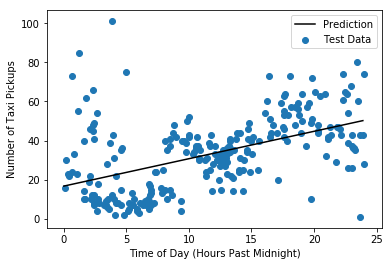

In [46]:
fitted_cab_model0 = LinearRegression().fit(X_train, y_train)
plot_cabs(fitted_cab_model0)

We can see that there's still a lot of variation in cab pickups that's not being caught by a linear fit. And the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. However, we can add columns to our design matrix for $TimeMin^2$ and $TimeMin^3$ and so on, allowing a wigglier polynomial that will better fit the data.

We'll be using sklearn's `PolynomialFeatures` to take some of the tedium out of building the new design matrix. In fact, if all we want is a formula like $y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + ...$ it will directly return the new design matrix.

In [47]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
new_features = transformer_3.fit_transform(X_train)
new_features

array([[6.73333333e+00, 4.53377778e+01, 3.05274370e+02],
       [2.18333333e+00, 4.76694444e+00, 1.04078287e+01],
       [1.41666667e+00, 2.00694444e+00, 2.84317130e+00],
       ...,
       [1.96666667e+01, 3.86777778e+02, 7.60662963e+03],
       [1.17333333e+01, 1.37671111e+02, 1.61534104e+03],
       [1.42000000e+01, 2.01640000e+02, 2.86328800e+03]])

A few notes on `PolynomialFeatures`:
- The interface is a bit strange. `PolynomialFeatures` is a 'transformer' in sklearn. We'll be using several transformers that learn a transformation on the training data and then apply that transformation on future data. On these (more typical) transformers it makes sense to have a `.fit()` and a separate `.transform()`. With PolynomialFeatures, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above.
- You rarely want to `include_bias` (a column of all 1s), since sklearn will add it automatically and statsmodels can just `add_constant` right before you fit to the design matrix
- If you want polynomial features for a several different variables, you should call `.fit_transform()` separately on each column and append all the results to the design matrix (unless you also want interaction terms between the newly-created features). See `np.concatenate` for joining arrays.

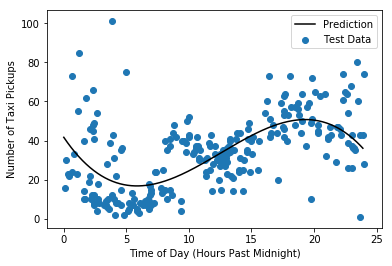

In [48]:
fitted_cab_model3 = LinearRegression().fit(new_features, y_train)
plot_cabs(fitted_cab_model3, transformer_3)

<div class="exercise"><b>Exercise 6</b></div>

**Questions**:
1. Calculate the polynomial model's $R^2$ performance on the test set. You may wish to write a function to build the design matrix. Without it, odds are you'll encounter a shape error you'll be seeing a lot.
2. Does the polynomial model improve on the purely linear model?
3. Make a residual plot for the polynomial model. What does this plot tell us about the model?

In [52]:
X_test_transf = transformer_3.fit_transform(X_test)
fitted_cab_model3.score(X_test_transf, y_test)

0.3341251257077831

#### Other features
Polynomial features are not the only constucted features that help fit the data. Because these data have a 24 hour cycle, we may want to build features that follow such a cycle. For example, $sin(24\frac{x}{2\pi})$, $sin(12\frac{x}{2\pi})$, $sin(8\frac{x}{2\pi})$. Other feature transformations are appropriate to other types of data. For instance certain feature transformations have been developed for geographical data.

<hr style="height:3px">
## Part 3: Exploring the Footbal data
Let's move on to a truly interesting dataset. The data imported below were scraped by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) and record various facts about players in the English Premier League. Our goal will be to fit models that predict the players' market value (what the player could earn when hired by a new team), as estimated by transfermrkt.com.

`name`: Name of the player  
`club`: Club of the player  
`age` : Age of the player  
`position` : The usual position on the pitch  
`position_cat` :  1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers  
`market_value` : As on transfermrkt.com on July 20th, 2017  
`page_views` : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_value` : Value in Fantasy Premier League as on July 20th, 2017  
`fpl_sel` : % of FPL players who have selected that player in their team  
`fpl_points` : FPL points accumulated over the previous season  
`region`: 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`: Player's nationality  
`new_foreign`: Whether a new signing from a different league, for 2017/18 (till 20th July)  
`age_cat`: a categorical version of the Age feature  
`club_id`: a numerical version of the Club feature  
`big_club`: Whether one of the Top 6 clubs  
`new_signing`: Whether a new signing for 2017/18 (till 20th July)  

As always, we first import, verify, split, and explore the data.

## Part 3.1: Import and verification

In [106]:
league_df = pd.read_csv("data/league_data.csv")
print(league_df.dtypes)
league_df.head()

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [58]:
league_df.describe()

,age,position_cat,market_value,page_views,fpl_value,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,460.000000,461.000000,461.000000,461.000000,461.000000,461.000000
mean,26.804772,2.180043,11.012039,763.776573,5.447939,57.314534,1.993478,0.034707,3.206074,10.334056,0.303688,0.145336
std,3.961892,1.000061,12.257403,931.805757,1.346695,53.113811,0.957689,0.183236,1.279795,5.726475,0.460349,0.352822
min,17.000000,1.000000,0.050000,3.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,3.000000,220.000000,4.500000,5.000000,1.000000,0.000000,2.000000,6.000000,0.000000,0.000000
50%,27.000000,2.000000,7.000000,460.000000,5.000000,51.000000,2.000000,0.000000,3.000000,10.000000,0.000000,0.000000
75%,30.000000,3.000000,15.000000,896.000000,5.500000,94.000000,2.000000,0.000000,4.000000,15.000000,1.000000,0.000000
max,38.000000,4.000000,75.000000,7664.000000,12.500000,264.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000


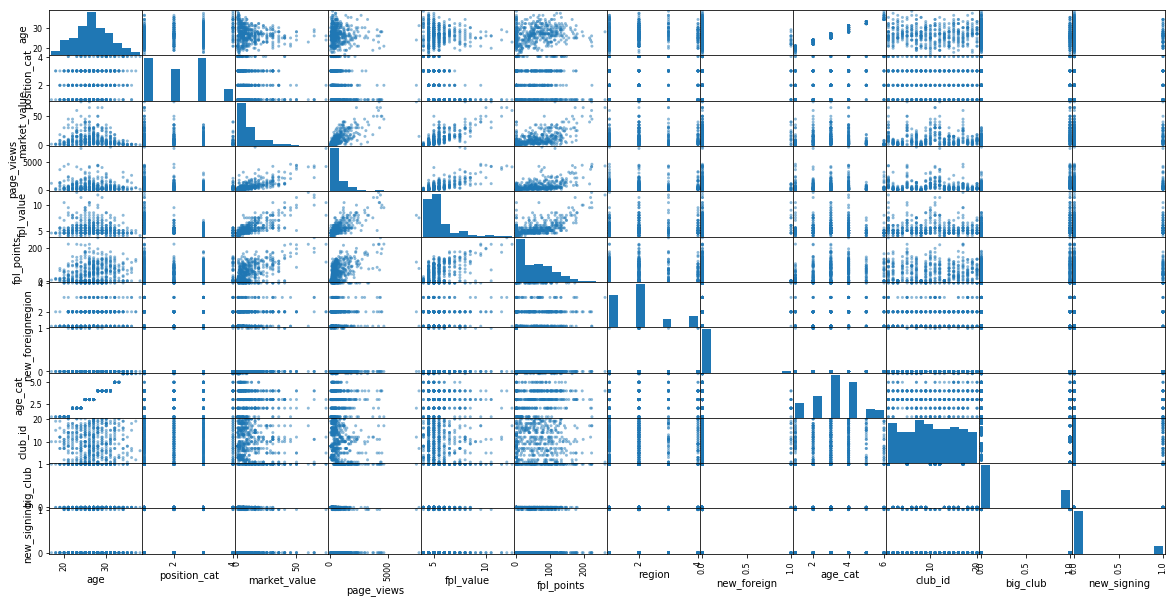

In [59]:
scatter_matrix(league_df, figsize=(20,10));

### Part 3.2: (Stratified) train/test split
We want to make sure that the training and test data have appropriate representation of each region; it would be bad for the training data to entirely miss a region. This is especially important because some regions are rather rare.

<div class="exercise"><b>Exercise 7</b></div>
**Questions**:
1. Use the `train_test_split` function to and its 'stratify' argument to split the data, keeping equal representation of each region (This will not work out of the box on this data. Deal with the resulting issue).
2. Deal with the issue you encountered above.
3. How did you deal with the error generated by `train_test_split`? How did you justify your action? 

In [107]:
try:
    # Doesn't work: a value is missing
    train_data, test_data = train_test_split(league_df, test_size = 0.2, stratify=league_df['region'])
except:
    # Count the missing lines and drop them
    missing_rows = np.isnan(league_df['region'])
    print("Uh oh, {} lines missing data! Dropping them".format(np.sum(missing_rows)))
    league_df = league_df.dropna(subset=['region'])
    train_data, test_data = train_test_split(league_df, test_size = 0.2, stratify=league_df['region'])

Uh oh, 1 lines missing data! Dropping them


## Part 3.3: Exploration
Now that we won't be peeking at the test set, let's explore and look for patterns! We'll introduce a number of useful pandas and numpy functions along the way. (Note: Homework 3 has you explore on the full dataset. What's the cost/benefit of exploring on the full data versus the training data?)

### Groupby
Pandas' `.groupby()` function is a wonderful tool for data analysis. It allows us to analyze each of several subgroups.

Many times, `.groupby()` is combined with `.agg()` to get a summary statistic for each subgroup. For instance: What is the average market value, median page views, and maximum fpl for each player position?

In [67]:
train_data.groupby('position').agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

,market_value,page_views,fpl_points
position,,,
AM,26.767857,995.5,218
CB,9.397761,281.0,178
CF,14.004808,764.5,224
CM,10.655000,389.5,149
DM,11.051724,476.0,105
GK,8.400000,447.5,149
LB,8.678571,338.5,177
LM,3.625000,325.5,99
LW,15.983333,516.0,264


<div class="exercise"><b>Exercise 8</b></div>
**Questions**:
1. What happens if we give `.groupyby()` multiple column names? What are the average market_value, page views, and fpl_points for each position within big clubs and within small clubs?
2. It is possible to loop over results returned by .groupby(). If we write `for x in df.groupby()`, what is stored in x? If we write `for y,z in df.groupby()`, what is stored in y and z? Does it depend on how many features we're grouping by? Write code to investigate.

In [70]:
train_data.groupby(['position','big_club']).agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

market_value  page_views  fpl_points
position big_club                                      
AM       0            12.107143       427.0         181
         1            41.428571      2252.0         218
CB       0             4.525000       204.5         131
         1            20.071429       834.0         178
CF       0             8.141892       541.0         166
         1            28.466667      2042.0         224
CM       0             6.263514       306.0          95
         1            23.153846      1498.0         149
DM       0             7.638889       268.5          80
         1            16.636364       892.0         105
GK       0             5.190476       344.0         149
         1            13.584615       721.0         143
LB       0             5.315789       185.0         135
         1            15.777778       566.0         177
LM       0             3.350000       304.0          99
         1             5.000000       936.0          26
LW       0             6.638889       384.5         117
         1            34.672222      2185.0         264
RB       0             4.595238       210.0         133
         1            16.250000       581.5         170
RM       0             6.250000       351.0           5
         1            22.000000      1519.0          83
RW       0             8.583333       454.0         149
         1            31.750000      1141.0         122
SS       0             6.916667       735.0         178

In [80]:
for x in train_data.groupby('position'):
    print(x)

('AM',                    name               club  age position  position_cat  \
118      Jason Puncheon     Crystal+Palace   31       AM             1   
378   Christian Eriksen          Tottenham   25       AM             1   
271  Henrikh Mkhitaryan  Manchester+United   28       AM             1   
244         David Silva    Manchester+City   31       AM             1   
407     Roberto Pereyra            Watford   26       AM             1   
183        Kasey Palmer       Huddersfield   20       AM             1   
440      Manuel Lanzini           West+Ham   24       AM             1   
351    Gylfi Sigurdsson            Swansea   27       AM             1   
240     Kevin De Bruyne    Manchester+City   26       AM             1   
218        Adam Lallana          Liverpool   29       AM             1   
214   Philippe Coutinho          Liverpool   25       AM             1   
1            Mesut Ozil            Arsenal   28       AM             1   
300        Siem de Jong   Newca

In [81]:
for y, z in train_data.groupby('position'):
    print('y = {0} and z = {1}'.format(y,z))

y = AM and z =                    name               club  age position  position_cat  \
118      Jason Puncheon     Crystal+Palace   31       AM             1   
378   Christian Eriksen          Tottenham   25       AM             1   
271  Henrikh Mkhitaryan  Manchester+United   28       AM             1   
244         David Silva    Manchester+City   31       AM             1   
407     Roberto Pereyra            Watford   26       AM             1   
183        Kasey Palmer       Huddersfield   20       AM             1   
440      Manuel Lanzini           West+Ham   24       AM             1   
351    Gylfi Sigurdsson            Swansea   27       AM             1   
240     Kevin De Bruyne    Manchester+City   26       AM             1   
218        Adam Lallana          Liverpool   29       AM             1   
214   Philippe Coutinho          Liverpool   25       AM             1   
1            Mesut Ozil            Arsenal   28       AM             1   
300        Siem de Jong

#### Using groupby
Let's use the groupby data to answer an investigative question: **How does player position affect the distribution of `market value`?** If we only wanted to know about the mean market value we could just .agg(), but here we want to study and plot the whole distribution. 

Notice:
 - We can set the
labels on each x tick to be the name of the given position
 - We make a plot for each different player position
 - Violin plots are good at showing where the mass of a distribution is, and boxplots are good at showing extreme values and outliers

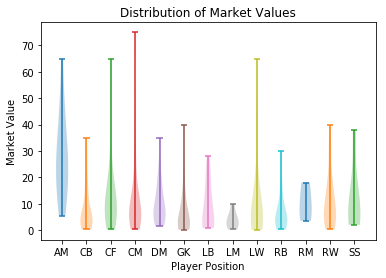

In [31]:
# plot several violin plots
cur_x_pos = 0

# for each position, violinplot the various market values of that group
for cur_player_position, cur_df in train_data.groupby('position'):
    plt.violinplot(cur_df['market_value'], positions=[cur_x_pos])
    cur_x_pos+=1

# get the name of each position and set the x ticks
position_names = [x[0] for x in train_data.groupby('position')]
plt.xticks(range(len(position_names)), position_names);

# fill in the remaining labels
plt.xlabel("Player Position")
plt.ylabel("Market Value")
plt.title("Distribution of Market Values")
plt.show()

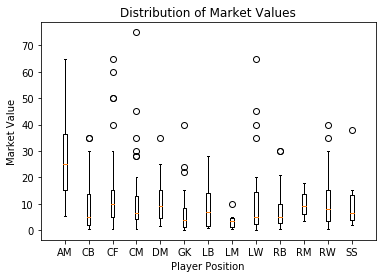

In [32]:
# again, but with box plots
cur_x_pos = 0
for cur_position,cur_df in train_data.groupby('position'):
    box_output = plt.boxplot(cur_df['market_value'], positions=[cur_x_pos])
    cur_x_pos+=1

# get the name of each position and set the x ticks
position_names = [x[0] for x in train_data.groupby('position')]
plt.xticks(range(len(position_names)), position_names);
plt.xlim(-1,len(position_names))

# fill in the remaining labels
plt.xlabel("Player Position")
plt.ylabel("Market Value")
plt.title("Distribution of Market Values")
plt.show()

<div class="exercise"><b>Exercise 9</b></div>
**Questions**
1. One SS (Second Striker) player is way outside the rest of the distribution. Who is it?

### Part 3.4: Deep explortation with groupby and plotting

We want to investigate the question **Does being at a big club versus a small club affect the distribution of market values at each position?**. This is a good chance to use a two-level groupby(): we'll need the various market values at each position/club combination, and we'll need to plot them

So we're all on the same page, we'll number each position according to this list, so AM is position 0, SS is position 12 and so forth.

In [86]:
position_names = [x[0] for x in train_data.groupby('position')]
position_names

['AM', 'CB', 'CF', 'CM', 'DM', 'GK', 'LB', 'LM', 'LW', 'RB', 'RM', 'RW', 'SS']

We're going to use an advanced feature of the violin plots: they can take in a _list_ of datasets and x positions, and not just a single dataset/x position!

<div class="exercise"><b>Exercise 10</b></div>
**Questions**:
1. build two lists of data for the big clubs: 
 - one list `bc_data` where bc_data[i] contains a column vector of the market values of players in a given poision at big clubs
 - one list `bc_x_pos` where bc_x_pos[i] is the index of that position in position_names. We'll use this as the x position of each violin
2. build the same two lists (`sc_data`, and `sc_x_pos`) for the small clubs. If you're an advanced coder, be sure you produce all lists in a single pass through the gropby data.
3. Verify that the big club lists are one element shorter than the small club lists, because big clubs are missing LM and SS.
4. Use the provided code to make a violinplot (or boxplot) of the market values at each club/position combination.

In [105]:
# your code here
big_club_df = train_data[train_data['big_club']==1]

bc_data = big_club_df.groupby('position').agg({
    'market_value': np.mean
})

bc_data.values()

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# the violinplot can take in a list where each entry is a dataset
plt.violinplot(bc_data, positions = bc_x_pos)
plt.violinplot(sc_data, positions = [x+.2 for x in sc_x_pos])

# properly label the x-axis
plt.xticks(range(len(position_names)), position_names);

# title, etc
plt.xlabel("Player Position")
plt.ylabel("Market Value")
plt.title("Distribution of Market Values")
plt.legend(["Big Clubs"])
plt.show()


<div class="notice"><b>Notice</b></div>
 - We plot each series at the same x value, but the second series is offset by a little (.2 in this case). This makes comparing distributions easier than if we had made two separate plots.
 - Putting a legend on this kind of violin plot is hard. We settle for just labeling one series.

<div class="exercise"><b>Exercise 11</b></div>
**Questions**:
1. What conclusions do you draw from the distributions above? What does the plot convey well, and what does it do poorly?
2. Do the results make sense, or could there be something fishy about our data?
3. What could we do with our plot if we wanted to additionally show the effect of `region`?

## Part 3 recap
In this section we covered
 - Verifying fresh data
 - Splitting into training and test sets with equal representation of given categories
 - Exploring relationships in the data via `.groupby` and `.agg`
 - Plotting the distribution of data via `violinplot` and `boxplot`

<hr style="height:3px">
## Part 4: Linear regression on the football data
This section of the lab focuses on fitting a model to the football data and interpreting the model results. The model we'll use is

$$\text{market_value} \approx \beta_0 + \beta_1\text{fpl_points} + \beta_2\text{age} + \beta_3\text{age}^2 + \beta_4log_2\left(\text{page_views}\right) + \beta_5\text{new_signing} +\beta_6\text{big_club} + \beta_7\text{position_cat}$$

We're including a 2nd degree polynomial in age because we expect pay to increase as a player gains experience, but then decrease as they continue aging. We're taking the log of page views because they have such a large, skewed range and the transformed variable will have fewer outliers that could bias the line. We choose the base of the log to be 2 just to make interpretation cleaner.

<div class="exercise"><b>Exercise 12</b></div>
**Questions**:
1. Build a design matrix function and fit this model to the training data. How good is the overall model?
2. Interpret the regression model. What is the meaning of the coefficient for:
    - fpl_points
    - age and age$^2$
    - $log_2($page_views$)$
    - new_signing
    - big_club
    - position_cat
2. What should a player do in order to improve their market value? How many page views should a player go get to increase their market value by 10?

In [122]:
def build_model2_design(df):
    design_mat = df[['fpl_points','age','new_signing','big_club','position_cat']].copy()
    design_mat['log_views'] = np.log2(df['page_views'])
    design_mat['age_squared'] = df['age']**2
    
    #reindex so variables are in a pretty order
    design_mat = design_mat[['fpl_points','age','age_squared','log_views','new_signing','big_club','position_cat']]
    
    design_mat = sm.add_constant(design_mat)
    
    return design_mat

y_train, design_mat = design_mat_transf(train_data)
design_mat.head()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<hr style='height:3px'>
### Part 4.2: Turning Categorical Variables into multiple binary variables
Of course, we have an error in how we've included player position. Even though the variable is numeric (1,2,3,4) and the model runs without issue, the value we're getting back is garbage. The interpretation, such as it is, is that there is an equal effect of moving from position category 1 to 2, from 2 to 3, and from 3 to 4, and that this effect is about -.61.

In reality, we don't expect moving from one position category to another to be equivalent, nor for a move from category 1 to category 3 to be twice as important as a move from category 1 to category 2. We need to introduce better features to model this variable.

We'll use `pd.get_dummies` to do the work for us.

In [43]:
train_design_recoded = pd.get_dummies(train_design, columns=['position_cat'], drop_first=True)
test_design_recoded = pd.get_dummies(test_design, columns=['position_cat'], drop_first=True)

train_design_recoded.head()

,const,fpl_points,age,age_squared,log_views,new_signing,big_club,position_cat_2,position_cat_3,position_cat_4
233,1.0,5,17,289,10.277287,0,1,0,0,0
44,1.0,36,21,441,8.977280,0,0,0,0,0
221,1.0,106,28,784,9.467606,0,1,0,1,0
324,1.0,12,21,441,6.781360,0,0,0,1,0
159,1.0,0,24,576,8.741467,0,0,0,0,0


We've removed the original `position_cat` column and created three new ones.

#### Why only three new columns?
Why does pandas give us the option to drop the first category? It's because keeping all four categories could cause an error in the model. To see why, suppose that the true beta values for the four columns were $[1,2,3,4]$ and the beta for the constant was $0$. A player in category 1 makes \$1 and a player in category 3 makes \$3. But if we change the values to be $[0,1,2,3]$ and $1$ a player in category 1 still makes \$1 and a player in category 3 still makes \$3. It becomes impossible for the model to decide which set of beta values to hand to us.

<div class="exercise"><b>Exercise 13</b></div>
**Questions**:
1. If we're fitting a model without a constant, should we have three dummy columns or four dummy columns?
2. Fit a model and interpret the coefficient of `position_cat_2`.


## Part 4 Recap:
In this section we covered
 - Building a design matrix for a complicated model
 - Interpreting model parameters, including those for tranformed and binary/dummy variables
 - Building multiple dummy variables to properly include categorical features in a multiple regression model